# Schwellwerte für die Objektdefinition

Ein Ansatz, um mögliche Schwellwerte für die Objektdefinion zu finden, ist die manuellen Fälle durchzugehen und zu schauen, was geeignete Schwellwerte sein könnten.

Dafür müssen wir erstmal ein paar Pakete laden

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import pandas as pd

import glob

import matplotlib.pyplot as plt
import seaborn as sns

track_folder = "/vols/talos/home/stephan/data/radar_track/trackdata/"

Um einen Überlick zu bekommen, wäre es vielleicht gut sich die Verteilung der Werte entlang der Tracks für alle Zeitschritte anzusehen. Dafür müssen wir alle Daten laden.

In [2]:
track_files = glob.glob("{}*.nc".format(track_folder))

In [3]:
len(track_files)

145

In [4]:
timesteps = np.arange(-30,35,5)

In [5]:
track_ravel_time = {t:[] for t in timesteps}

In [6]:
test = xr.open_dataset(track_files[100])

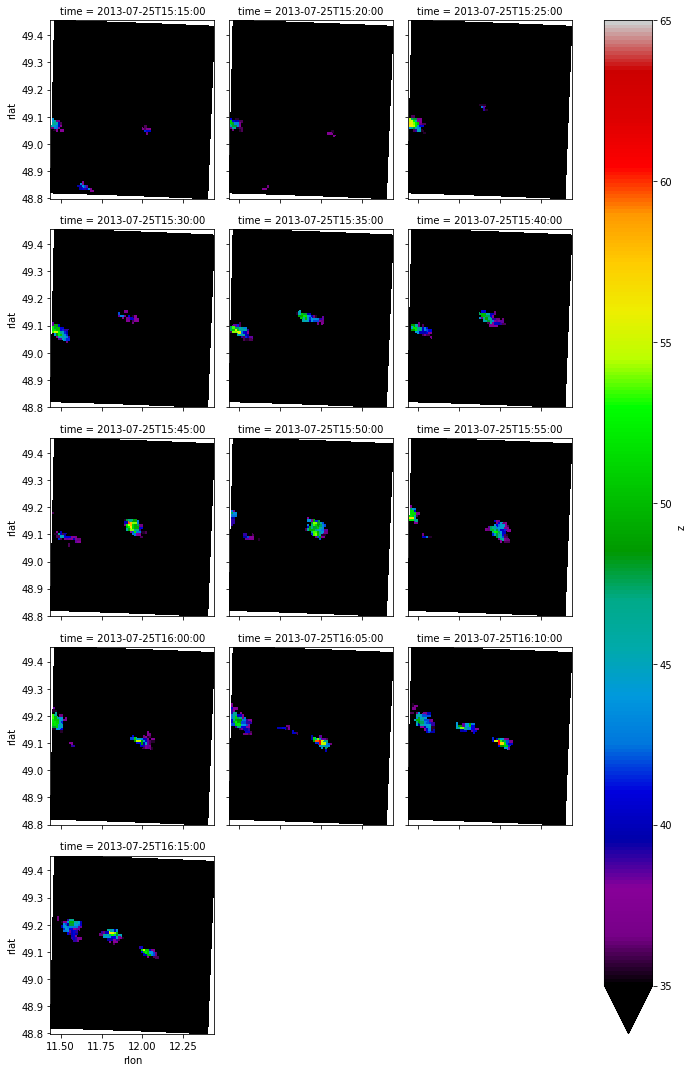

In [7]:
test.z.plot(x='rlon',y='rlat',col='time',col_wrap=3,vmin=35,vmax=65,cmap='nipy_spectral')

IndexError: index 12 is out of bounds for axis 0 with size 12

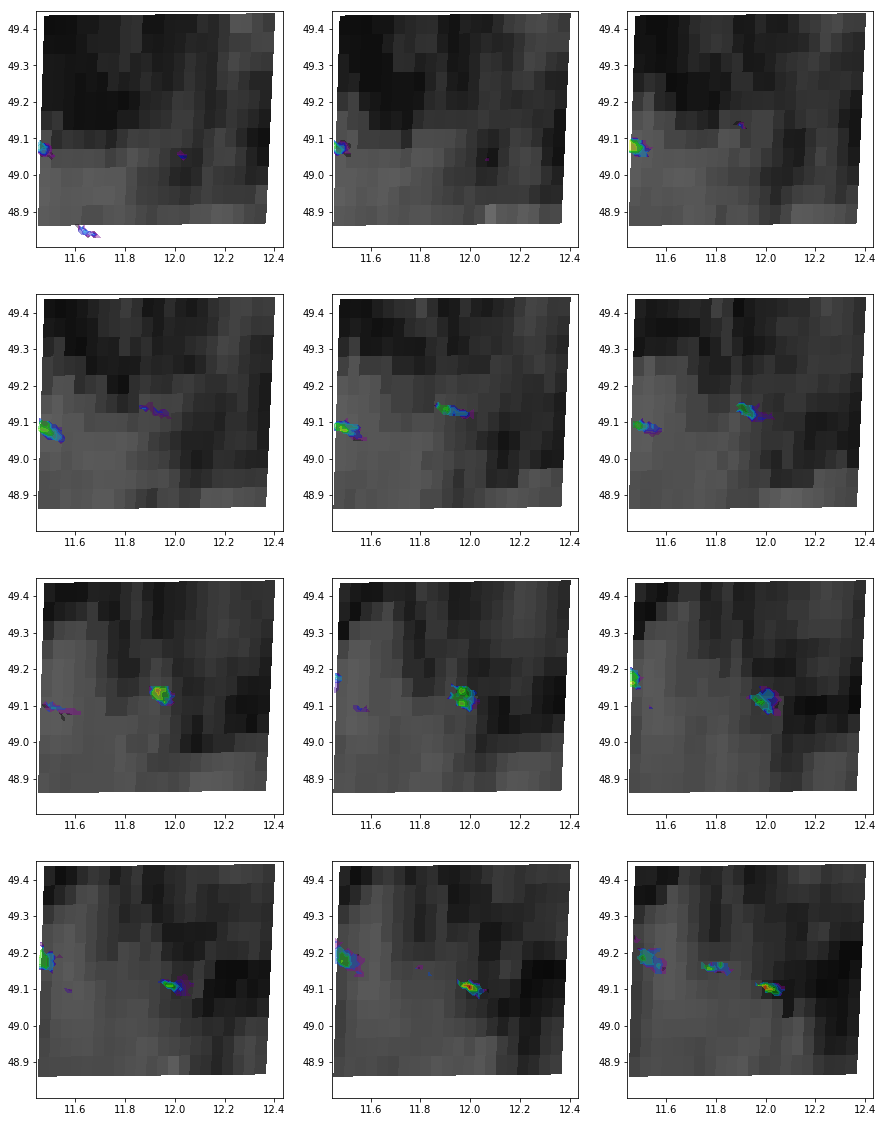

In [8]:
fig,ax = plt.subplots(4,3,figsize=(15,20))
axs = ax.ravel()
for i, v in enumerate(test.vis006.data):
    axs[i].pcolormesh(test.lon.data,test.lat.data,v,vmin=0,vmax=1,cmap='gray')
    axs[i].contourf(test.rlon.data,test.rlat.data,np.ma.masked_less(test.z.data[i],35),vmin=35,vmax=65,cmap='nipy_spectral',alpha=0.4)

## Test mit IR 10,8 µm

Wir sehen uns testweise die Werte für den IR-10,8-µm-Kanal an.

In [9]:
track_ravel_time = {t:[] for t in timesteps}

for track in track_files:
    track_data = xr.open_dataset(track)
    
    for i,time in enumerate(timesteps):
        track_ravel_time[time] = track_ravel_time[time] + track_data.ir108.data[i].ravel().tolist()

/home/lenk/.local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,u'IR 10,8 \xb5m nach Zeitschritt, alle 143 Tracks')

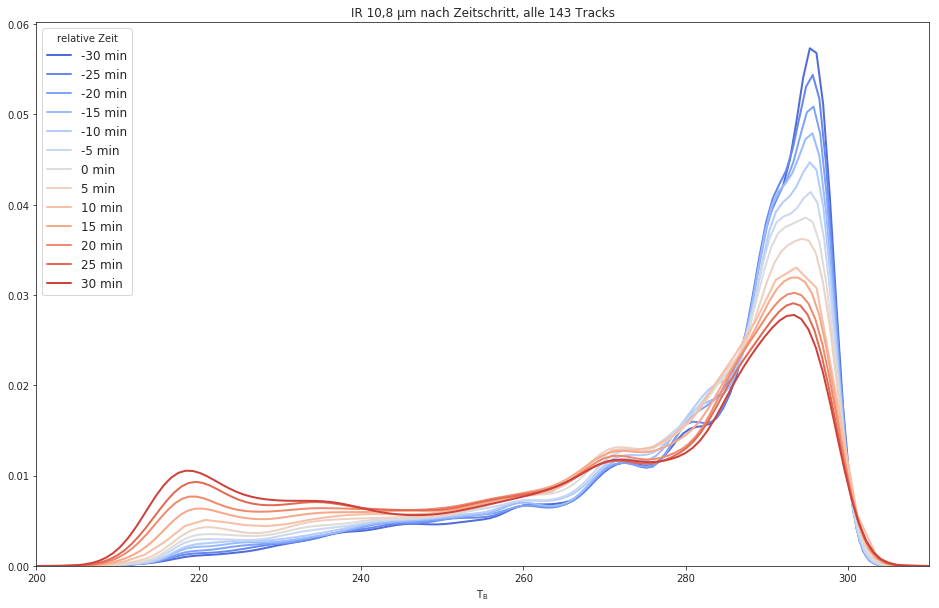

In [10]:
sns.set_palette("coolwarm",13)
sns.set_style("ticks")

fig, ax = plt.subplots(1,1,figsize=(16,10))

for time in timesteps:
    # Dichtegraph
    sns.distplot(track_ravel_time[time], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = "{} min".format(time),ax=ax)
    
# Grafikformatierung
plt.legend(prop={'size': 12}, title = 'relative Zeit')
ax.set_xlim(200,310)
ax.set_xlabel(r'T$_\mathrm{B}$')
ax.set_title(u"IR 10,8 µm nach Zeitschritt, alle 143 Tracks")

Es sieht so aus, als könnte man zwei "Populationen" trennen. Zu Beginn der Tracks gibt es mehr Pixel im Bereich zwischen 260 und 300 K und weniger im kälteren Bereich. Mit zunehmender Tracklänge nimmt der Anteil der warmen Pixel ab und der der kälteren zu. Das heißt, die konvektiven Wolken nehmen mehr Raum im Ausschnitt um den Trackpunkt ein. Den Schwellwert könnte man innerhalb des Plateaus zwischen 260 bis 240 K ansetzen. Als Ansatzpunkt fangen wir mit 250 K an.


### Ein festgesetzer Schwellwert

Wir variieren den Schwellwert jetzt zwischen 260 bis 240 K und sehen mal, wie weit in den Anfangsbereich wir ein Objekt definieren können. Dazu wählen wir zunächst ein Beispiel aus.

In [11]:
beispiel = xr.open_dataset(track_files[100])

beispiel_ir108 = beispiel.ir108.data

IndexError: index 13 is out of bounds for axis 0 with size 13

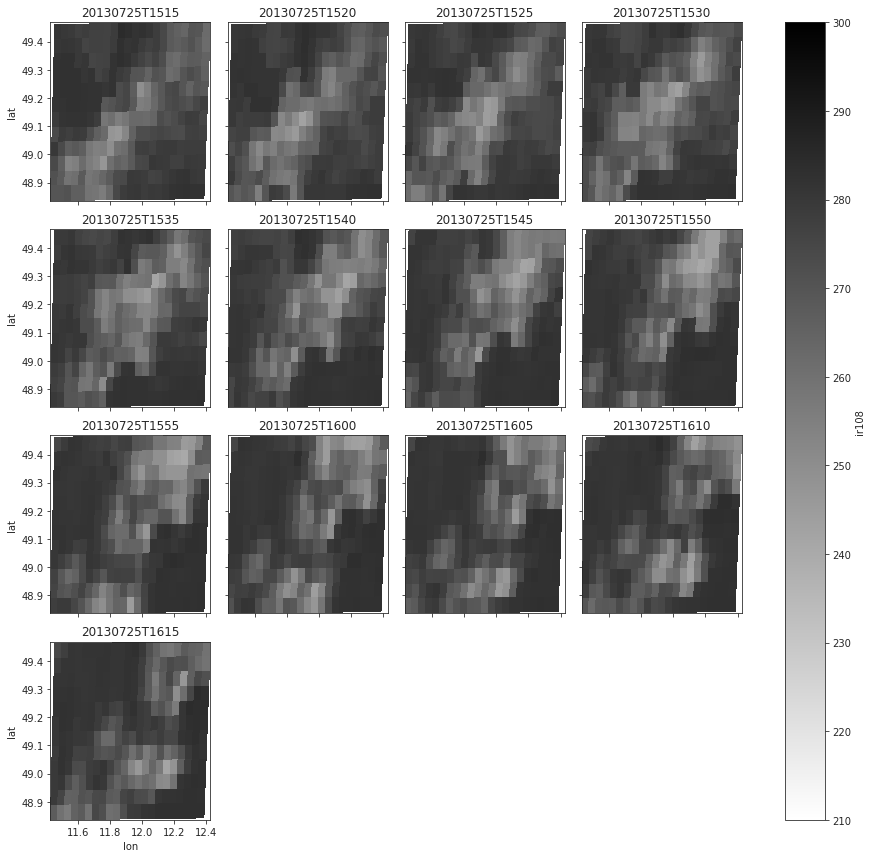

In [12]:
beispiel_plot = beispiel.ir108.plot(x='lon',y='lat',col='time',col_wrap=4,vmin=210,vmax=300,cmap='gray_r')

for i, ax in enumerate(beispiel_plot.axes.flat):
    ax.set_title(pd.Timestamp(beispiel.time.data[i]).strftime("%Y%m%dT%H%M"))

In [13]:
thresholded = np.ma.masked_greater(beispiel.ir108.data,250)

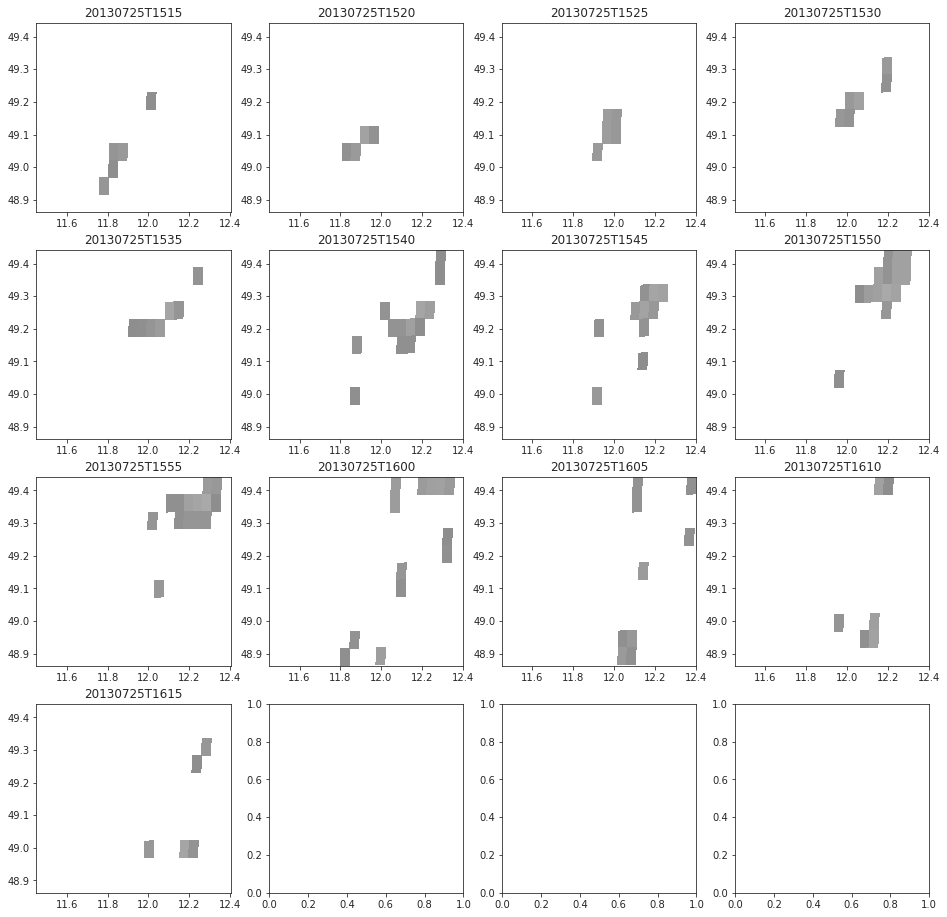

In [14]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i, data in enumerate(thresholded):
    axs[i].pcolormesh(beispiel.lon.data,beispiel.lat.data,data,vmin=210,vmax=300,cmap='gray_r')
    axs[i].set_title(pd.Timestamp(beispiel.time.data[i]).strftime("%Y%m%dT%H%M"))

Am Ende des Tracks kann man so das Objekt ganz gut erfassen, aber am Anfang springt es doch ziemlich. Vielleicht ist ein strengerer Schwellwert eine Lösung?

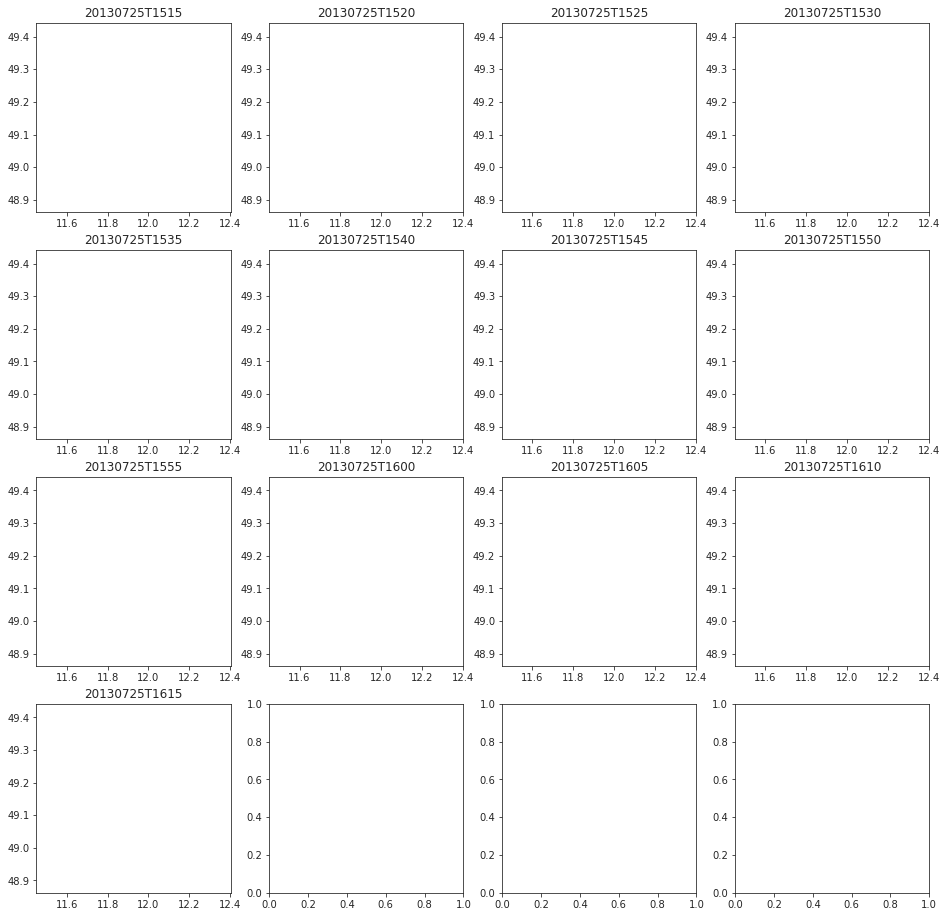

In [15]:
thresholded = np.ma.masked_greater(beispiel.ir108.data,240)
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i, data in enumerate(thresholded):
    axs[i].pcolormesh(beispiel.lon.data,beispiel.lat.data,data,vmin=210,vmax=300,cmap='gray_r')
    axs[i].set_title(pd.Timestamp(beispiel.time.data[i]).strftime("%Y%m%dT%H%M"))

Das sieht besser aus, aber nun reicht die Objektdefinition nicht sehr weit vor den CI-Zeitpunkt, aber das ist zu erwarten. Vielleicht hilft auch ein adaptiver Schwellwertansatz?

### Adaptiver Schwellwert

Man könnte aus den Daten für jeden Zeitschritt einen adaptiven Schwellwert berechnen. Möglichkeiten wären

1. Quantile der Datenverteilung
2. wenn die Daten normalverteilt sind so etwas wie $\pm 3 \sigma$ (z.B. Zinner et al 2008)
3. entropiebasierte Verfahren (z.B. Otsu- oder Yen-Verfahren)
4. ...

#### Quantile

Für den IR-10,8-µm-Kanal bieten sich die unteren Quantile, also z.B. das 5%-Quantil an.

In [16]:
quantile_thresholds = [np.quantile(d,0.05) for d in beispiel.ir108.data]

In [17]:
quantile_thresholds

[255.66557032033342,
 254.82639752079191,
 254.17597903443476,
 253.0389831609413,
 253.57974565059783,
 250.7644841786034,
 253.20969753037468,
 249.96255143293223,
 249.3000663866256,
 249.9937664908602,
 253.23966516867344,
 251.9970534568211,
 257.2321687299368]

In [36]:
quantile_masked = [np.ma.masked_greater(beispiel.ir108.data[i],quantile_thresholds[i]) 
                            for i in xrange(len(beispiel.ir108.data))]

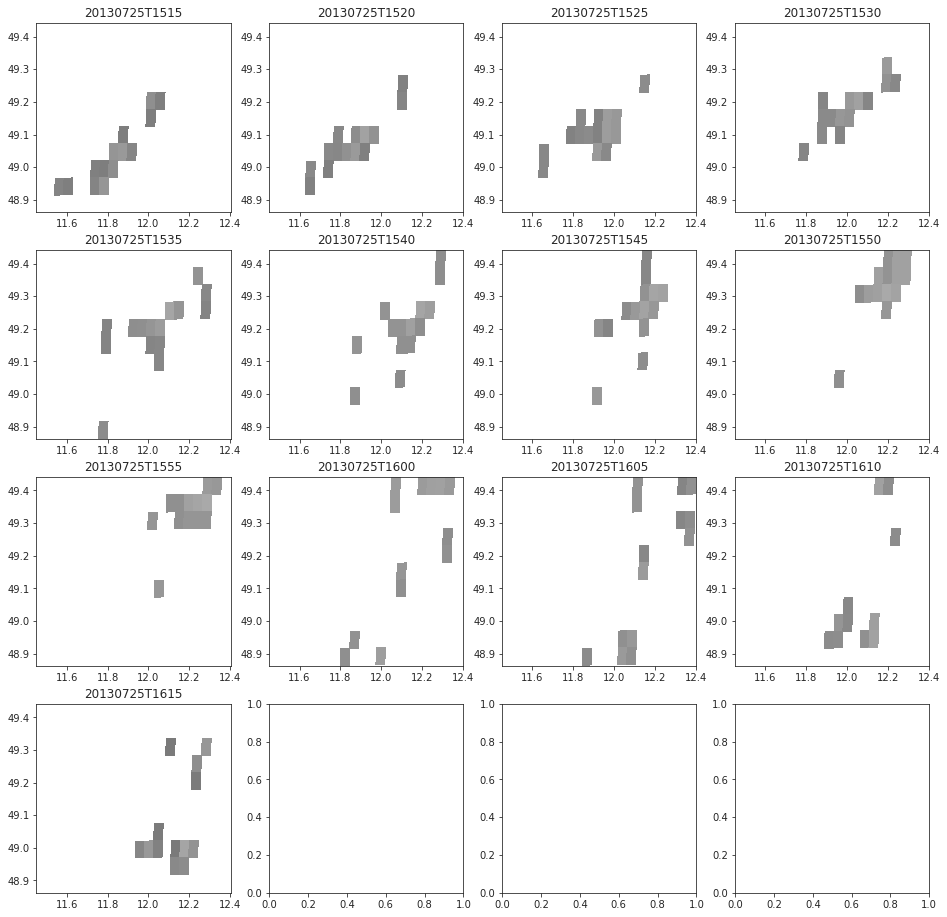

In [37]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i, d in enumerate(quantile_masked):
    axs[i].pcolormesh(beispiel.lon.data,beispiel.lat.data,d,vmin=210,vmax=300,cmap='gray_r')
    axs[i].set_title(pd.Timestamp(beispiel.time.data[i]).strftime("%Y%m%dT%H%M"))

Das erlaubt ein Objekt weiter in bis zum Trackanfang zu verfolgen, bringt aber das Problem mit sich, das manchaml mehrere mögliche Objekte gefunden werden. Aber das Problem lässt sich wahrscheinlich durch das Überlappungstracking beheben.

#### Normalverteilung und $\pm 3\sigma$

Wie oben zu sehen ist, sind die Daten nicht normalverteilt. Aber vielleicht können wir sie in eine Normalverteilung transformieren. 

Zuerst normalisieren wir sie in den Bereich -1 und 1.

In [38]:
def scale_array_min_max(array_data,vmin=None, vmax=None,new_max=1,new_min=0):
    """
    Scales a array into the range of [0,1] using the minimum and maximum value
    of the array.
    
    Inputs:
    -------
    array_data: numpy array of floats or integers, 2d
        array to scale
        
    Returns:
    --------
    scaled_array: numpy array of floats, 2d
    """

    # determine extremes of the given array
    if not vmin:
        array_min = np.nanmin(array_data)
    else:
        array_min = vmin
    
    if not vmax:
        array_max = np.nanmax(array_data)
    else:
        array_max = vmax

    # scale array
    a = (new_max - new_min) / (array_max - array_min)
    b = new_max - a * array_max

    scaled_array = a * array_data + b
    
    return scaled_array

In [22]:
data_norm = [scale_array_min_max(d,new_min=-1,new_max=1)
             for d in beispiel.ir108.data]

(array([  17.,   30.,  191.,  417.,  433.,  531.,  895.,  668., 1326.,
        1117.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

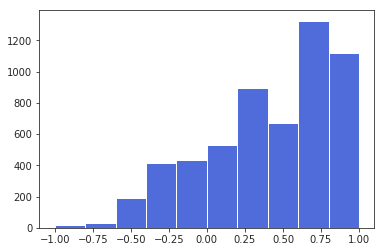

In [23]:
plt.hist(data_norm[6].ravel())

Die Verteilung ist immernoch linksschief, aber das kann man vielleicht mit einer Transformation beheben. Möglich wäre, z.B. die Werte vom Maximum abzuziehen und dann die Wurzel aus den Werten zu ziehen.

In [24]:
data_trans = [np.sqrt(1-d)
             for d in data_norm]

(array([  3.,  14.,  64., 140., 129., 153., 299., 357., 483., 381., 367.,
        252., 275., 312., 462., 370., 270., 304., 240., 259., 277., 161.,
         14.,  25.,  14.]),
 array([0.        , 0.05656854, 0.11313708, 0.16970563, 0.22627417,
        0.28284271, 0.33941125, 0.3959798 , 0.45254834, 0.50911688,
        0.56568542, 0.62225397, 0.67882251, 0.73539105, 0.79195959,
        0.84852814, 0.90509668, 0.96166522, 1.01823376, 1.07480231,
        1.13137085, 1.18793939, 1.24450793, 1.30107648, 1.35764502,
        1.41421356]),
 <a list of 25 Patch objects>)

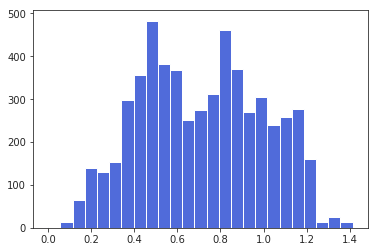

In [25]:
plt.hist(np.ma.masked_invalid(data_trans[6].ravel()),bins=25)

Das sieht immer noch nicht gut normalverteilt aus, aber schon besser.

In [26]:
thrsholds = [np.nanmean(d) + 3*np.nanstd(d) for d in data_trans]

In [27]:
thrsholds 

[1.4277185327117026,
 1.4639696232827681,
 1.5417409395513384,
 1.609112569410157,
 1.6480382828566298,
 1.6424056293434255,
 1.568230559165777,
 1.523948613818765,
 1.5055044644701094,
 1.4939461316146891,
 1.4732302425368362,
 1.5027379238201797,
 1.5503513076545494]

In [28]:
data_trans_masked = [np.ma.masked_less(data_trans[i],thrsholds[i]) 
                            for i in xrange(len(beispiel.ir108.data))]

data_masked = [np.ma.masked_where(d,data_trans_masked[i].mask==True)
               for i,d in enumerate(beispiel.ir108.data)]

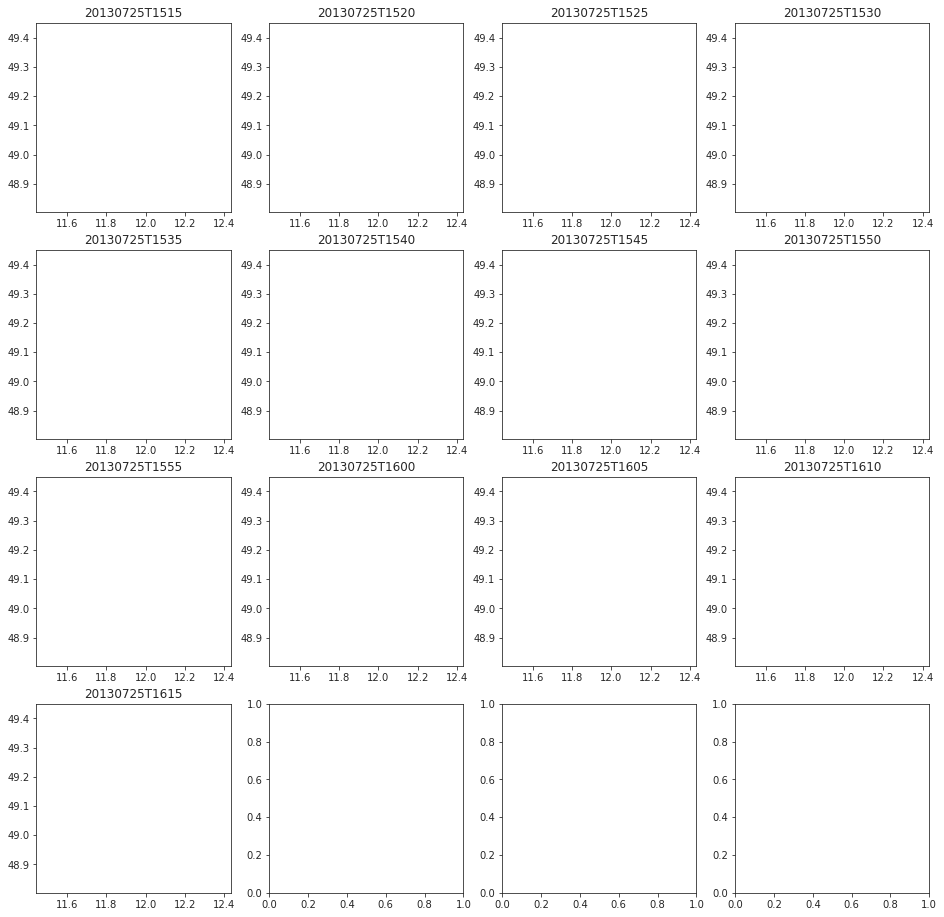

In [30]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i, d in enumerate(data_masked):
    axs[i].pcolormesh(beispiel.lon.data,beispiel.lat.data,d,vmin=210,vmax=300,cmap='gray_r')
    axs[i].set_title(pd.Timestamp(beispiel.time.data[i]).strftime("%Y%m%dT%H%M"))

Das funktioniert noch nicht.